# Simple Reinforcement Learning with Tensorflow: Part 0 - Q-Networks
In this iPython notebook we implement a Q-Network algorithm that solves the FrozenLake problem. To learn more, read here: https://medium.com/@awjuliani/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0

For more reinforcment learning tutorials, see:
https://github.com/awjuliani/DeepRL-Agents

In [1]:
from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

### Load the environment

In [2]:
env= gym.make("Breakout-v0")
# env = gym.make("FrozenLake-v0")
# env.step

[2017-10-03 03:06:23,539] Making new env: Breakout-v0


In [3]:
actions = env.action_space
observations = env.observation_space
rst = env.reset()
observation,reward,done,info = env.step(0)

def filter_observation(observation):
    """This module will return index of ball and index of
    plate in 2D coordinate"""
    sample = observation[100:185,10:150,:]
    panel = observation[180:195,10:150,:]
    ball_index = np.unravel_index(sample.argmax(), sample.shape)
    plate_index = np.unravel_index(panel.argmax(), panel.shape)
    return np.array(list(ball_index[0:2])+list(plate_index[0:2])).reshape(1,4)
    

filtered_observation = filter_observation(observation)


## The Q-Network Approach

### Implementing the network itself

In [5]:
tf.reset_default_graph()

In [6]:
#These lines establish the feed-forward part of the network used to choose actions
inputs1 = tf.placeholder(shape=[1,4],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([4,6],0,0.01))
Qout = tf.matmul(inputs1,W)
predict = tf.argmax(Qout,1)

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,6],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

### Training the network

In [7]:
pbar = tqdm(total=2000)#progress bar variable
init = tf.global_variables_initializer()

# Set learning parameters
y = .99
e = 0.1
num_episodes = 2000
#create lists to contain total rewards and steps per episode
jList = []
rList = []

with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        s = filter_observation(s)
        rAll = 0
        d = False
        j = 0
        #The Q-Network
        s1,r,d,_ = env.step(1)
        while j < 99:
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            a,allQ = sess.run([predict,Qout],feed_dict={inputs1:s})
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
            #Get new state and reward from environment
            s1,r,d,_ = env.step(a[0])
#             env.render()
            s1 = filter_observation(s1)
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout,feed_dict={inputs1:s1})
            #Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            #Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,W],feed_dict={inputs1:s1,nextQ:targetQ})
            rAll += r
            s = s1
            if d == True:
                #Reduce chance of random action as we train the model.
                e = 1./((i/50) + 10)
                break
        jList.append(j)
        rList.append(rAll)
        pbar.update(1)
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

100%|██████████| 2000/2000 [05:09<00:00,  6.50it/s]

Percent of succesful episodes: 0.1235%


In [53]:
np.random.rand(1) < 1./((i/50) + 10)

array([False], dtype=bool)

### Some statistics on network performance

We can see that the network beings to consistly reach the goal around the 750 episode mark.

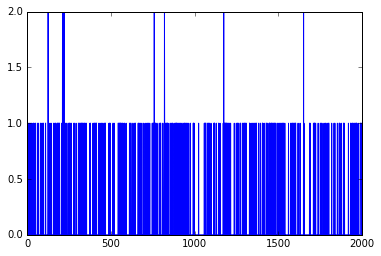

In [7]:
plt.plot(rList)

It also begins to progress through the environment for longer than chance aroudn the 750 mark as well.

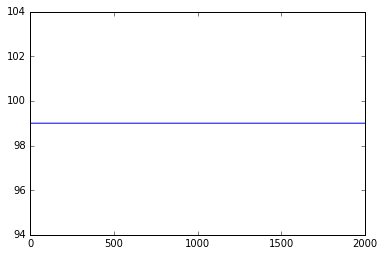

In [8]:
plt.plot(jList)

In [ ]:
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
